#### Setting up LLM

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
llm =  ChatGroq(model="llama-3.3-70b-versatile")

#### Example 1: Generating a funnier joke

In [2]:
from typing import Annotated, List
import operator
from typing_extensions import Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict

#### Creating State Schema

In [3]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )

# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)

#### Node Functions

In [4]:
def llm_call_generator(state: State):
    """LLM generates a joke"""
    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""
    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}

# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""
    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"

#### StateGraph

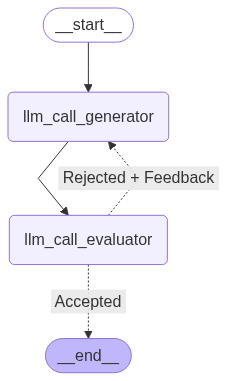

In [5]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

optimizer_builder = StateGraph(State)

optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

optimizer_workflow = optimizer_builder.compile()
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [6]:
state = optimizer_workflow.invoke({"topic": "Orange cat"})
print(state)

{'joke': "Why did the orange cat join a band?\n\nBecause it wanted to be the purr-cussionist and have a mew-sical career that was the cat's meow, and it was a paws-itive hit with its fur-iendly fans, and it was an orange you glad it didn't turn out to be a cat-astrophe.", 'topic': 'Orange cat', 'feedback': 'The joke is funny because it uses multiple cat-related puns in a creative way, making it a paws-itive and amusing play on words.', 'funny_or_not': 'funny'}


#### Example 2: Generating a code based on its simplicity

In [11]:
# Graph state
class State(TypedDict):
    code: str
    topic: str
    feedback: str
    simplicity: str

# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["simple", "complicated"] = Field(
        description="Decide if the code is simple or complicated to understand.",
    )
    feedback: str = Field(
        description="If the code is complicated, provide feedback on how to improve it.",
    )

# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)

In [12]:
def code_generator(state: State):
    """LLM generates a code"""
    if state.get("feedback"):
        msg = llm.invoke(
            f"Provide a Python code for {state['topic']} but take into account the feedback: {state['feedback']}. Use markdown formatting."
        )
    else:
        msg = llm.invoke(f"Provide a  python code for {state['topic']}")
    return {"code": msg.content}

def code_evaluator(state: State):
    """LLM evaluates the code"""
    grade = evaluator.invoke(f"Grade the code {state['code']}")
    return {"simplicity": grade.grade, "feedback": grade.feedback}

# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_code(state: State):
    """Route back to code generator or end based upon feedback from the evaluator"""
    if state["simplicity"] == "simple":
        return "Accepted"
    elif state["simplicity"] == "complicated":
        return "Rejected + Feedback"

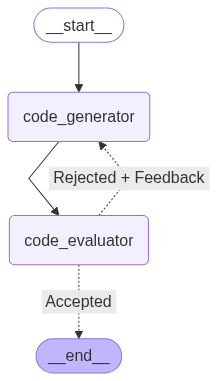

In [13]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

builder = StateGraph(State)

builder.add_node("code_generator", code_generator)
builder.add_node("code_evaluator", code_evaluator)

builder.add_edge(START, "code_generator")
builder.add_edge("code_generator", "code_evaluator")
builder.add_conditional_edges(
    "code_evaluator",
    route_code,
    {  # Name returned by route_code : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "code_generator",
    },
)

workflow = builder.compile()
display(Image(workflow.get_graph().draw_mermaid_png()))

In [15]:
from IPython.display import Markdown
state = workflow.invoke({"topic": "Fibonacci Series"})
Markdown(state['code'])

**Fibonacci Series in Python**
================================

The Fibonacci series is a series of numbers in which each number is the sum of the two preceding ones, usually starting with 0 and 1.

**Code**
--------

```python
def fibonacci(n):
    """
    Generate the Fibonacci series up to the nth term.

    Args:
        n (int): The number of terms in the series.

    Returns:
        list: A list of Fibonacci numbers.
    """
    fib_series = [0, 1]
    while len(fib_series) < n:
        fib_series.append(fib_series[-1] + fib_series[-2])
    return fib_series

# Example usage:
n = 10  # number of terms
fib_series = fibonacci(n)
print(f"Fibonacci series up to {n} terms: {fib_series}")
```

**How it Works**
----------------

1. The `fibonacci` function takes an integer `n` as input, representing the number of terms in the series.
2. We initialize the `fib_series` list with the first two Fibonacci numbers, 0 and 1.
3. We use a while loop to generate the remaining terms in the series.
4. In each iteration, we append the sum of the last two numbers in the series to the `fib_series` list.
5. Once the series has `n` terms, we return the `fib_series` list.
6. In the example usage, we call the `fibonacci` function with `n = 10` and print the resulting series.

**Output**
----------

```
Fibonacci series up to 10 terms: [0, 1, 1, 2, 3, 5, 8, 13, 21, 34]
```

**Alternative Implementation**
---------------------------

If you prefer a recursive implementation, you can use the following code:

```python
def fibonacci_recursive(n):
    if n <= 1:
        return n
    return fibonacci_recursive(n-1) + fibonacci_recursive(n-2)

def fibonacci_series(n):
    return [fibonacci_recursive(i) for i in range(n)]

# Example usage:
n = 10
fib_series = fibonacci_series(n)
print(f"Fibonacci series up to {n} terms: {fib_series}")
```

Note that the recursive implementation has a higher time complexity than the iterative implementation and may not be suitable for large values of `n`.

In [16]:
print("\nTOPIC\n",state['topic'])
print("\nFEEDBACK:\n",state['feedback'])
print("\nSIMPLICITY:\n",state['simplicity'])


TOPIC
 Fibonacci Series

FEEDBACK:
 The code is well-structured and easy to understand. It uses clear and descriptive variable names and includes docstrings to explain the purpose of each function. The example usage and output are also provided, making it simple for users to understand how to use the code.

SIMPLICITY:
 simple
